# Task 1: Kaggle Cats and Dogs Classification

# Part 1: Training

In [135]:
import torch
import torchvision as tv
from torchvision import transforms, datasets
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim 

# fix random seed for reproducability
torch.manual_seed(1)

In [136]:
# Parameters
path_train='./cats_and_dogs_filtered/train/'
batch_size_train = 200 # samples per batch to load
num_workers_train = 0 # subprocesses for data loading
l_rate = 0.001 # learning rate
size_compressed = [80,80] # size of each image after compression


## Dataset Preprocessing

$\bullet$ Load training data and convert them to specific format (including changes of size, grayscale, number of channels and datatype) 

In [137]:
train_transform = tv.transforms.Compose([
    tv.transforms.Grayscale(num_output_channels=1), # reduce the channel Nr. to one
    tv.transforms.Resize(size_compressed),
    tv.transforms.ToTensor()
])
train_data = tv.datasets.ImageFolder(root = path_train, transform = train_transform)
train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size_train,
                                           num_workers = num_workers_train, shuffle = True)
print(train_data.class_to_idx) # return: dict with items (class_name, class_index)

{'cats': 0, 'dogs': 1}


$\bullet$ Check some samples of our loaded training data

In [138]:
examples = enumerate(train_loader)
batch_idx, (images, labels) = next(examples)

print('Shape of one training mini batch: ', images.shape)
print('Shape of one label mini batch: ', labels.shape)
print('Data from the first image: \n', images[0])
print('Labels of one batch: \n', labels[:])
print(train_loader.dataset)

Shape of one training mini batch:  torch.Size([200, 1, 80, 80])
Shape of one label mini batch:  torch.Size([200])
Data from the first image: 
 tensor([[[0.6196, 0.6627, 0.6431,  ..., 0.6118, 0.8510, 0.9020],
         [0.6431, 0.6471, 0.6353,  ..., 0.5765, 0.8941, 0.9451],
         [0.6196, 0.6353, 0.6510,  ..., 0.5412, 0.8627, 0.9490],
         ...,
         [0.1765, 0.2157, 0.2314,  ..., 0.7569, 0.7333, 0.7098],
         [0.1490, 0.1686, 0.2078,  ..., 0.7765, 0.7725, 0.7333],
         [0.1490, 0.1804, 0.1647,  ..., 0.7922, 0.7882, 0.7725]]])
Labels of one batch: 
 tensor([0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1,
        1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0,
        1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1,
        0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0,
        0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1,
        1, 1, 0, 0, 1, 0, 1,

$\bullet$ Visualize some examples with their labels

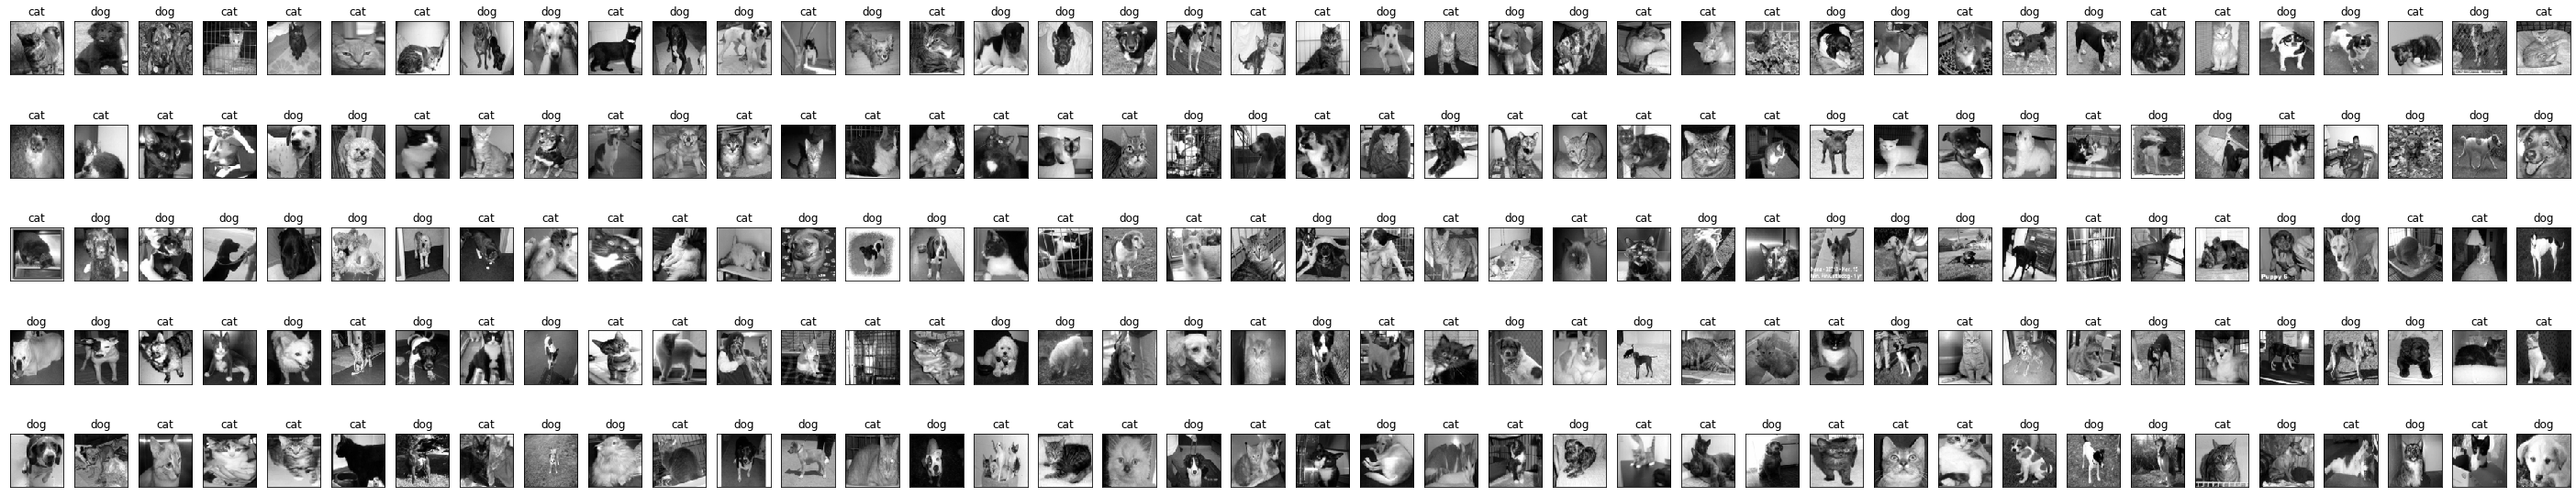

In [139]:
# plot images from the first batch with corresponding labels
classes = ['cat', 'dog']
fig = plt.figure(figsize=(50, 10))
for idx in np.arange(batch_size_train):
    axes = fig.add_subplot(5, batch_size_train/5, idx+1, xticks=[], yticks=[])
    plt.imshow(images[idx].squeeze(), cmap='gray')
    axes.set_title("{}".format(classes[labels[idx]]))

## Defining the CNN

In [140]:
class CNN(nn.Module):
    """ 
    Create CNN model with convolutional net (for feature extraction) and 
    fully connected layers (for binary classification)
    """
    def __init__(self):
        super(CNN, self).__init__()
        # define the number of neurons in convolutional layers
        num_filters = [1, 64, 64, 128, 128]
        # define the number of neurons in fully connected layers
        num_neurons_fully = [256, 64]
        
        # compute the first convolution layer, some details see: [1]
        # [1]: https://pytorch.org/docs/stable/nn.html?highlight=conv2d#torch.nn.Conv2d
        # input.size([1,80,80])
        self.con1 = nn.Conv2d(in_channels = num_filters[0], 
                      out_channels = num_filters[1], 
                      kernel_size = 5, 
                      padding = 1,
                      bias = False)  # output.size([64, 77, 77])
        # compute a max pooling layer
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # output.size([64, 39, 39])
        # batch nornamlization
        self.bn1 = nn.BatchNorm2d(num_features=num_filters[1])
        
        self.con2= nn.Conv2d(in_channels = num_filters[1],
                      out_channels = num_filters[2], 
                      kernel_size = 3, 
                      padding = 1,
                      bias = False)  # output.size([64, 38, 38])
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)  # output.size([64, 19, 19])
        self.bn2 = nn.BatchNorm2d(num_features=num_filters[2])
        
        self.con3 = nn.Conv2d(in_channels = num_filters[2],
                      out_channels = num_filters[3], 
                      kernel_size = 3, 
                      padding = 1,
                      bias = False)  # output.size([128, 18, 18])
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)  # output.size([128, 9, 9])
        self.bn3 = nn.BatchNorm2d(num_features=num_filters[3])
        
        self.con4 = nn.Conv2d(in_channels = num_filters[3],
                      out_channels = num_filters[4], 
                      kernel_size = 3, 
                      padding = 1,
                      bias = False)  # output.size([128, 8, 8])
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)  # output.size([128, 4, 4])
        self.bn4 = nn.BatchNorm2d(num_features=num_filters[4])
        
        self.fc1 = nn.Linear(num_filters[4]*4*4, num_neurons_fully[0], bias=True)
        self.fc2 = nn.Linear(num_neurons_fully[0], num_neurons_fully[1], bias=True)
        self.fc3 = nn.Linear(num_neurons_fully[1], 2, bias=True)
    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.con1(x))))
        x = self.pool2(F.relu(self.bn2(self.con2(x))))
        x = self.pool3(F.relu(self.bn3(self.con3(x))))
        x = self.pool4(F.relu(self.bn4(self.con4(x))))
        x = x.view(-1, 128*4*4)  # flatten to 1D
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.sigmoid(self.fc3(x))
        return x

$\bullet$ Layout of the CNN

In [141]:
kaggle_model = CNN()
print(kaggle_model)
params = list(kaggle_model.parameters())
print(params[2].shape)

CNN(
  (con1): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1), bias=False)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (con2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (con3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (con4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn4): BatchNorm2d(128, eps

## Training Procedure

In [142]:
def train(NeuralNetwork, train_loader, loss_function, num_epochs, learning_rate, wd=0):
    """
    Trains a neural network.
    
    Parameters:
    NeuralNetwork: neural network to be trained
    dataloader: DataLoader that deals batches for mini-batch learning
    loss_function: cost function to be optimized
    num_epochs: number of training epochs
    learning_rate: learning rate
    wd: weight decay regularization (default value 0)
    """
    optimizer = torch.optim.Adam(NeuralNetwork.parameters(), lr=learning_rate, weight_decay=wd) 
    for epoch in range(num_epochs):
        running_loss = 0.0
        errors = 0
        for batch_idx, (inputs,labels) in enumerate(train_loader):
            # reset gradient
            optimizer.zero_grad()
            # forward propagation
            outputs = NeuralNetwork(inputs)
            # compute loss
            loss = loss_function(outputs, labels)
            # backprop
            loss.backward()
            # update parameters
            optimizer.step()
            # add loss
            running_loss += loss.item()
            # error rate
            predicted = torch.max(outputs,dim=1) 
            errors += sum(predicted[1] != labels)
            if (batch_idx % 200) == 0:
                print('Current loss ',running_loss/(batch_idx+1))
        print('Epoch: ',epoch+1,'Error rate on training set:', round(100.0* errors.numpy() / len(train_loader.dataset),2), '%')
    print('Finished Training')

## Train the CNN

In [143]:
train(kaggle_model, train_loader, nn.CrossEntropyLoss(), 20, l_rate)

Current loss  0.6894473433494568
Epoch:  1 Error rate on training set: 40.75 %
Current loss  0.6103463172912598
Epoch:  2 Error rate on training set: 30.85 %
Current loss  0.532835066318512
Epoch:  3 Error rate on training set: 25.5 %
Current loss  0.4914538264274597
Epoch:  4 Error rate on training set: 22.95 %
Current loss  0.4644262194633484
Epoch:  5 Error rate on training set: 17.95 %
Current loss  0.43568095564842224
Epoch:  6 Error rate on training set: 14.5 %
Current loss  0.4362521469593048
Epoch:  7 Error rate on training set: 14.3 %
Current loss  0.43235766887664795
Epoch:  8 Error rate on training set: 12.2 %
Current loss  0.4112379550933838
Epoch:  9 Error rate on training set: 10.8 %
Current loss  0.3766464591026306
Epoch:  10 Error rate on training set: 8.65 %
Current loss  0.3820401132106781
Epoch:  11 Error rate on training set: 8.5 %
Current loss  0.39109012484550476
Epoch:  12 Error rate on training set: 5.6 %
Current loss  0.3676583170890808
Epoch:  13 Error rate on

##  Save the model

In [144]:
torch.save(kaggle_model,'kaggle_model_2.pkl') #save the parameters of te net